# Proyek Analisis Data: Clustering

**Nama:** Ghiffari Kenang Sagraha \
**Email:** ghiffarisagraha@apps.ipb.ac.id \
**ID Dicoding:** ghiffariks


# **1. Perkenalan Dataset**

Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Sumber: [kaggle](https://www.kaggle.com/datasets/harunrai/fintech-customer-life-time-value-ltv-dataset/data). Dataset dapat diperoleh dari , seperti public repositories *Kaggle*
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset yang diambil terpenuhi bahwa tidak memiliki label atau kelas
   - **Jumlah Baris**: Dataset yang diambil memiliki sebanyak 7000 baris
   - **Tipe Data**: Telah terpenuhi bahwa dataset memiliki fitur **kategorikal** dan **numerikal**. 

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak digunakan dalam kasus ini

## 1.1 Deskripsi Dataset

FinTech (Digital Wallet) Customer Lifetime Value (LTV) Dataset for Analysis

**Description:** \
This dataset helps to predict the Customer Lifetime Value (LTV) for users of digital wallets, specifically targeting platforms like PayTM and Khalti. The dataset contains about 7,000 samples with 20 rich features capturing customer demographics, transaction history, engagement metrics, app usage patterns, support interactions, etc.

# 2. Import Library

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# 3. Memuat Dataset

In [3]:
#membaca dataset menggunakan relative path
df = pd.read_csv("./Dataset_clustering.csv")  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  7000 non-null   object 
 1   Age                          7000 non-null   int64  
 2   Location                     7000 non-null   object 
 3   Income_Level                 7000 non-null   object 
 4   Total_Transactions           7000 non-null   int64  
 5   Avg_Transaction_Value        7000 non-null   float64
 6   Max_Transaction_Value        7000 non-null   float64
 7   Min_Transaction_Value        7000 non-null   float64
 8   Total_Spent                  7000 non-null   float64
 9   Active_Days                  7000 non-null   int64  
 10  Last_Transaction_Days_Ago    7000 non-null   int64  
 11  Loyalty_Points_Earned        7000 non-null   int64  
 12  Referral_Count               7000 non-null   int64  
 13  Cashback_Received 

In [5]:
df.head()

Customer_ID  Age  Location Income_Level  Total_Transactions  \
0   cust_0000   54     Urban          Low                 192   
1   cust_0001   67  Suburban         High                 979   
2   cust_0002   44     Urban         High                 329   
3   cust_0003   30     Rural         High                  71   
4   cust_0004   58     Urban       Middle                 878   

   Avg_Transaction_Value  Max_Transaction_Value  Min_Transaction_Value  \
0           16736.384023           60216.834510            6525.814861   
1           14536.734683           48350.100272            2186.742245   
2            7061.372800           32521.157187            2743.406808   
3           16426.876453           17827.896720            4360.784994   
4           10800.092660           17497.634534            4532.872520   

    Total_Spent  Active_Days  Last_Transaction_Days_Ago  \
0  3.213386e+06          140                        209   
1  1.423146e+07          229                        240   
2  2.323192e+06           73                         21   
3  1.166308e+06          299                        285   
4  9.482481e+06          236                        329   

   Loyalty_Points_Earned  Referral_Count  Cashback_Received  \
0                   2114              25        2224.012140   
1                   2960              20        4026.823518   
2                   3170               0        1441.011395   
3                   4756              35        4365.855580   
4                   1992              18        4161.523827   

  App_Usage_Frequency Preferred_Payment_Method  Support_Tickets_Raised  \
0             Monthly               Debit Card                       3   
1             Monthly                      UPI                      17   
2             Monthly               Debit Card                      11   
3              Weekly           Wallet Balance                       6   
4               Daily                      UPI                      18   

   Issue_Resolution_Time  Customer_Satisfaction_Score           LTV  
0              61.568590                            1  3.279546e+05  
1              60.392889                            8  1.437053e+06  
2              45.305579                            4  2.419387e+05  
3              22.030191                            1  1.284599e+05  
4              20.634723                            5  9.569514e+05

## Insights
* terdapat banyak fitur numerik disini, yakni: `Age`, `Location`, `Income_Level`, `Total_Transactions`, `Avg_Transactions_Value`, `Max_Transactions_Value`, `Min_Transactions_Value`, `Total_Spent`, `Active_Days`, `Last_Transactions_Days_Ago`, `Loyalty_Points_Earned`, `Referral_Count`, `Cashback_Received`, `Support_Tickets_Raised`, `Customer_Satisfaction_Score`, dan `LTV`
* lalu, terdapat fitur kategorik yakni: `location`, `Income_Level`, `App_Usage_Frequency`, dan `Preferred_Payment_Method`
* Dataset ini umum digunakan untuk permasalah regeresi, yakni mendapatkan nilai LTV dari customer, tapi dalam hal ini akan dilakukan clustering supaya mendapatkan jenis customer berdasarkan loyalitas. 

# 4. Exploratory Data Analysis

## 4.1 Memahami Struktur Data

Pertama, didefinisikan fitur numerik dan kategorik supaya mempermudah pemrosesan data selanjutnya

In [6]:
num_features = [
    "Age", "Total_Transactions", "Avg_Transaction_Value", "Total_Spent",
    "Max_Transaction_Value", "Min_Transaction_Value", "Active_Days",
    "Last_Transaction_Days_Ago", "Loyalty_Points_Earned", "Referral_Count",
    "Cashback_Received", "Support_Tickets_Raised", "Issue_Resolution_Time",
    "Customer_Satisfaction_Score", "LTV"
]

cat_features = ["Location", "Income_Level", "App_Usage_Frequency", "Preferred_Payment_Method"]

In [7]:
df.describe()

Age  Total_Transactions  Avg_Transaction_Value  \
count  7000.000000         7000.000000            7000.000000   
mean     42.633714          501.221429            9946.831482   
std      15.516036          286.277311            5780.880831   
min      16.000000            1.000000              10.185827   
25%      29.000000          252.000000            4907.466790   
50%      43.000000          506.000000            9841.172643   
75%      56.000000          744.000000           14955.048801   
max      69.000000         1000.000000           19996.445086   

       Max_Transaction_Value  Min_Transaction_Value   Total_Spent  \
count            7000.000000            7000.000000  7.000000e+03   
mean            30159.596784            2981.549953  5.002022e+06   
std             21996.108793            2197.342161  4.390495e+06   
min                31.857484               4.617966  1.498144e+03   
25%             12224.329366            1233.066226  1.363991e+06   
50%             25469.392130            2473.181073  3.756105e+06   
75%             44515.414177            4378.759195  7.645508e+06   
max             98809.241533            9917.028823  1.946773e+07   

       Active_Days  Last_Transaction_Days_Ago  Loyalty_Points_Earned  \
count  7000.000000                7000.000000            7000.000000   
mean    181.934857                 183.847714            2501.545429   
std     105.102598                 105.063709            1446.680026   
min       1.000000                   1.000000               0.000000   
25%      90.000000                  93.000000            1254.750000   
50%     182.000000                 184.000000            2466.000000   
75%     273.000000                 275.000000            3792.250000   
max     365.000000                 365.000000            5000.000000   

       Referral_Count  Cashback_Received  Support_Tickets_Raised  \
count     7000.000000        7000.000000             7000.000000   
mean        24.837000        2496.525032               10.017571   
std         14.560352        1440.651412                6.037067   
min          0.000000           0.234349                0.000000   
25%         12.000000        1269.423703                5.000000   
50%         25.000000        2478.943350               10.000000   
75%         37.000000        3749.375251               15.000000   
max         50.000000        4999.698480               20.000000   

       Issue_Resolution_Time  Customer_Satisfaction_Score           LTV  
count            7000.000000                  7000.000000  7.000000e+03  
mean               36.528007                     5.479000  5.119197e+05  
std                20.389399                     2.860197  4.390551e+05  
min                 1.019853                     1.000000  3.770495e+03  
25%                19.127302                     3.000000  1.482058e+05  
50%                36.257396                     5.000000  3.878180e+05  
75%                54.068594                     8.000000  7.748578e+05  
max                71.978946                    10.000000  1.956988e+06

## 4.2 Menangani Data yang Hilang

In [8]:
df.isna().sum()

Customer_ID                    0
Age                            0
Location                       0
Income_Level                   0
Total_Transactions             0
Avg_Transaction_Value          0
Max_Transaction_Value          0
Min_Transaction_Value          0
Total_Spent                    0
Active_Days                    0
Last_Transaction_Days_Ago      0
Loyalty_Points_Earned          0
Referral_Count                 0
Cashback_Received              0
App_Usage_Frequency            0
Preferred_Payment_Method       0
Support_Tickets_Raised         0
Issue_Resolution_Time          0
Customer_Satisfaction_Score    0
LTV                            0
dtype: int64

tidak ada missing values sehingga tidak perlu ditangani apa apa

## 4.3 Analisis Distribusi dan Korelasi

### 4.3.1 Analisis Korelasi pada Fitur Numerik

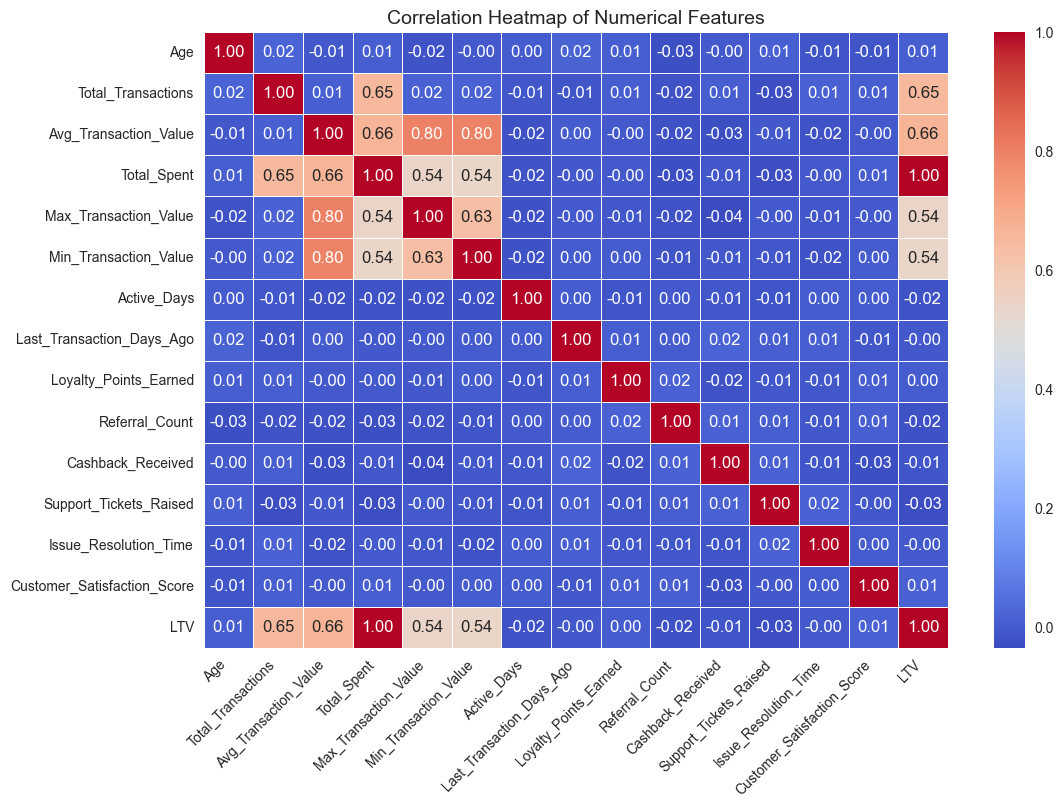

In [9]:
corr_matrix = df[num_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

#### Insights: <a id='corr_matrix'></a>
* Perhatikan bahwa fitur yang berkaitan dengan `Transactions` memiliki korelasi yang tinggi satu sama lain, terutama pada `LTV` dengan `Total_Spent` yang memiliki korelasi pearson sebesar 100%. Hal ini menandakan bahwa perhitungan nilai LTV sangat kuat dipengaruhi oleh nilai `Total_Transactions`.
* Di lain sisi, terlihat bahwa loyalty points tidak dipengaruhi dengan kuat atau moderat oleh fitur numerik lainnya

### 4.3.2 Analisis Distribusi Data

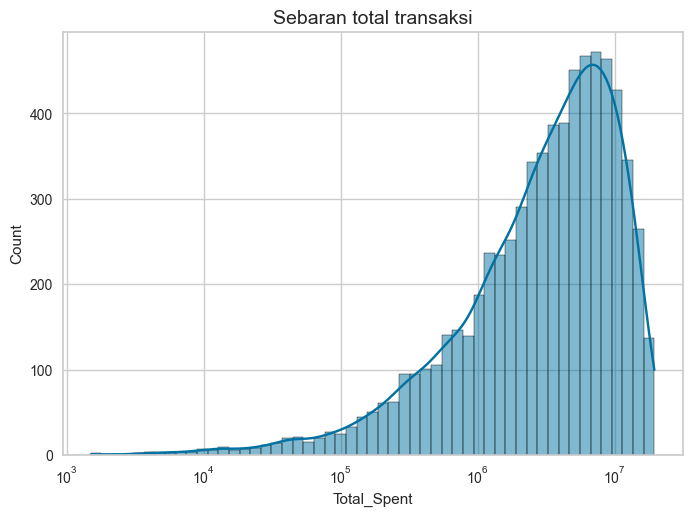

In [10]:
sns.histplot(data=df, x=df['Total_Spent'], kde=True, log_scale=True)
plt.title("Sebaran total transaksi", fontsize=14)
plt.show()

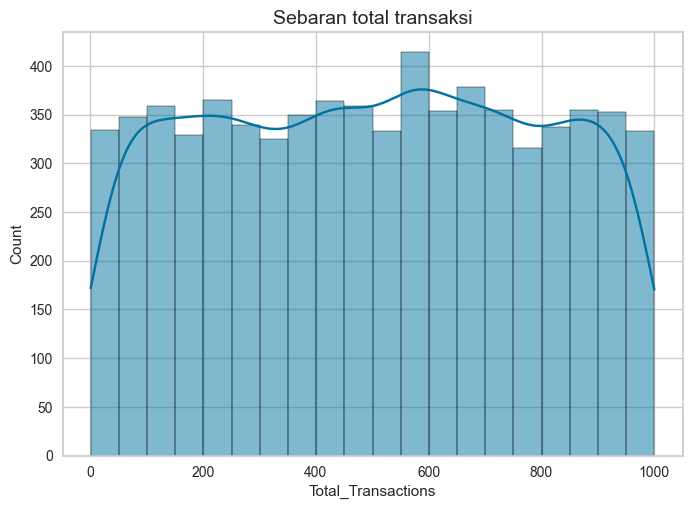

In [11]:
sns.histplot(data=df, x=df['Total_Transactions'], kde=True)
plt.title("Sebaran total transaksi", fontsize=14)
plt.show()

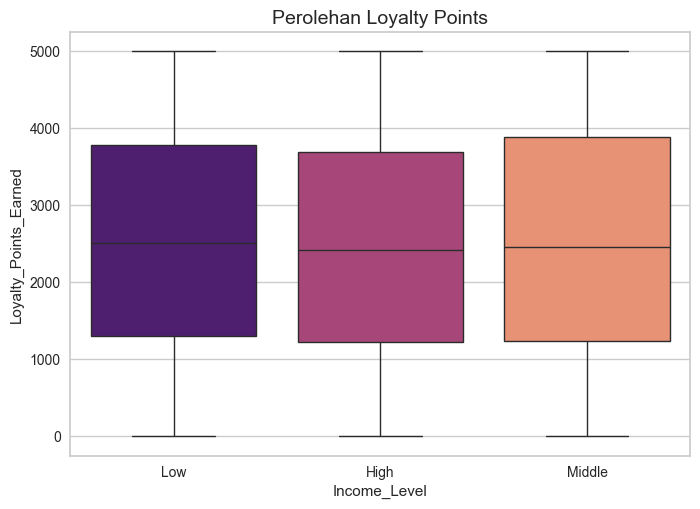

In [12]:
sns.boxplot(data=df, y=df['Loyalty_Points_Earned'], x=df['Income_Level'], hue=df['Income_Level'], palette="magma")
plt.title("Perolehan Loyalty Points", fontsize=14)
plt.show()

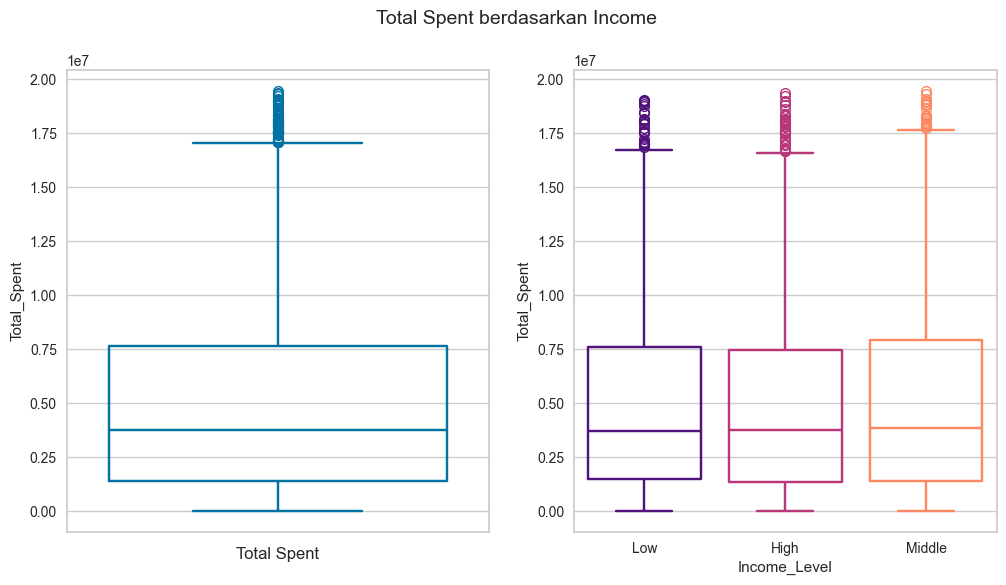

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
plt.suptitle("Total Spent berdasarkan Income", fontsize=14)

sns.boxplot(data=df, y=df['Total_Spent'], fill=False, ax=ax1)
ax1.set_xlabel("Total Spent", fontsize=12)

sns.boxplot(data=df, y=df['Total_Spent'], x=df['Income_Level'], hue='Income_Level',  fill=False, ax=ax2, palette="magma")
plt.show()

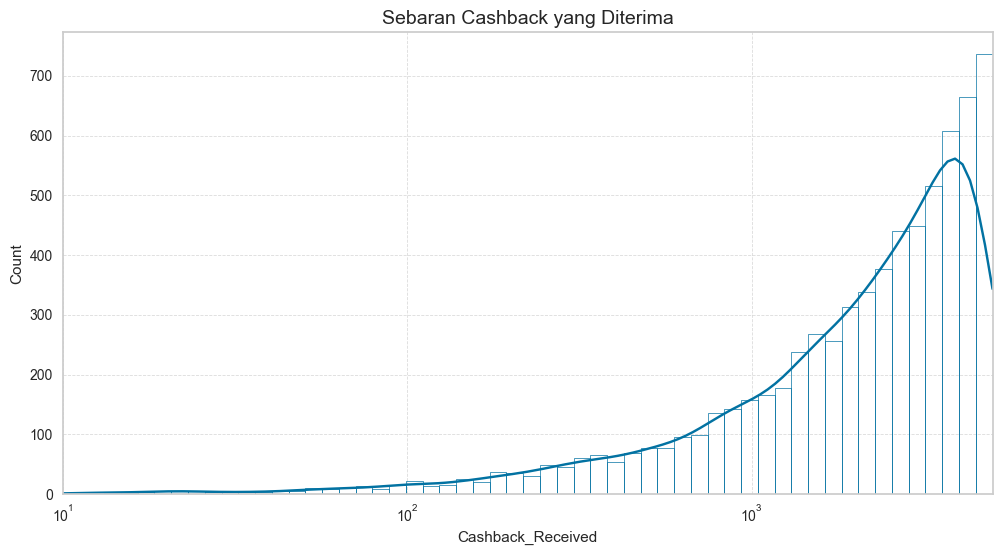

In [14]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df, x='Cashback_Received', kde=True, log_scale=True, fill=False) 
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.title("Sebaran Cashback yang Diterima", fontsize=14)

ax.set_xlim(10, df['Cashback_Received'].max()) 
plt.show()

#### Insights
* Perhatikan sebaran Total Transaksi yang left skewed, Sebaran Cashback yang left skewed dengan mode yang berada di ujung kanan tetapi memiliki range x axis yang berbeda. **Mengartikan bahwa Standarisasi Data perlu dilakukan untuk bisa mendapatkan skala yang sama dengan sebaran normal standar**
* Perhatikan histogram Total Transaksi. Frekuensi total transaksi yang tersebar fluktuatif pada range 0-1000, yang juga menandakan perlu adanya standarisasi Data.
* Perhatikan Boxplot Loyalty Points, didapat bahwa tidak ada outlier dan tersebar cukup seimbang diatara kategori Income_Level. Juga tidak terdapat outlier pada loyalty Points. Ini menadakan bahwa **tidak perlu penanganan outlier**
* Perhatikan boxplot Total Spent berdasarkan Income, didapatkan bahwa Total Spent secara keseluruhan tidak memiliki outlier, tetapi bila dilihat dengan kategorisasi menggunakan income_level, didapat adanya outlier. secara umum, disimpulkan bahwa **tidak perlu penanganan outlier**

# 5. Data Preprocessing

## 5.1 Menghapus atau Menangani Data kosong

In [15]:
df.isna().sum()

Customer_ID                    0
Age                            0
Location                       0
Income_Level                   0
Total_Transactions             0
Avg_Transaction_Value          0
Max_Transaction_Value          0
Min_Transaction_Value          0
Total_Spent                    0
Active_Days                    0
Last_Transaction_Days_Ago      0
Loyalty_Points_Earned          0
Referral_Count                 0
Cashback_Received              0
App_Usage_Frequency            0
Preferred_Payment_Method       0
Support_Tickets_Raised         0
Issue_Resolution_Time          0
Customer_Satisfaction_Score    0
LTV                            0
dtype: int64

tidak ada missing values sehingga tidak perlu ditangani apa apa

## 5.2 Menangani Data Duplikat

untuk menangani data duplikat, hanya perlu melihat `Customer_ID` saja karena pad fitur lainnya, data duplikat tidak menjadi masalah

In [16]:
df['Customer_ID'].duplicated().sum()

0

tidak ada data duplikat sehingga tidak perlu ditangani apa apa

## 5.3 Normalisasi atau Standarisasi Fitur

Akan dilakukan standarisasi pada fitur numerik untuk menyeimbangkan skala yang ada antara satu fitur dengan fitur lainnya

In [17]:
scaler = StandardScaler()
scaled_num = scaler.fit_transform(df[num_features])
scaled_num_df = pd.DataFrame(scaled_num, columns=num_features)

Tidak dilakukan Normalisasi karena tidak membantu proses pembentukan cluster

## 5.4 Deteksi dan Penanganan Outlier

Untuk menangani Outlier, outlier akan dibatasi ke batas atas atau batas bawah IQR

In [18]:
def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

df = cap_outliers_iqr(df, num_features)

## 5.4 Encoding Data Kategorikal

Dilakukan One Hot Encoding pada fitur kategorik karena label encoder tidak berarti banyak bagi model clusterisasi

In [19]:
encoder = OneHotEncoder(drop='first')
encoded_cat = encoder.fit_transform(df[cat_features])
encoded_cat_df = pd.DataFrame(encoded_cat.toarray(), columns=encoder.get_feature_names_out(cat_features))

processed_df = pd.concat([scaled_num_df, encoded_cat_df], axis=1)
checkpoint_df = processed_df.copy()

## 5.5 Binning (Pengelompokkan Data)

Binning dalam hal ini ditujukan untuk keperluan EDA, bukan untuk clustering. Ini dilakukan sebagai pembanding antara binning dengan hasil cluster

In [20]:
bins_tot_trans = np.linspace(df['Total_Transactions'].min(), df['Total_Transactions'].max(), num=6) 
bins_tot_spent = np.linspace(df['Total_Spent'].min(), df['Total_Spent'].max(), num=6)
bins_tot_loyal = np.linspace(df['Loyalty_Points_Earned'].min(), df['Loyalty_Points_Earned'].max(), num=6)

df_num = df[num_features]
df_num['bin_total_transaction'] = pd.cut(df_num['Total_Transactions'], bins=bins_tot_trans)
df_num['bin_total_spent'] = pd.cut(df_num['Total_Spent'], bins=bins_tot_spent)
df_num['bin_total_loyal'] = pd.cut(df_num['Loyalty_Points_Earned'], bins=bins_tot_loyal)

C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_23116\3701561848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['bin_total_transaction'] = pd.cut(df_num['Total_Transactions'], bins=bins_tot_trans)
C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_23116\3701561848.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['bin_total_spent'] = pd.cut(df_num['Total_Spent'], bins=bins_tot_spent)
C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_23116\3701561848.py:8: SettingWithCopyWarning: 
A value is try

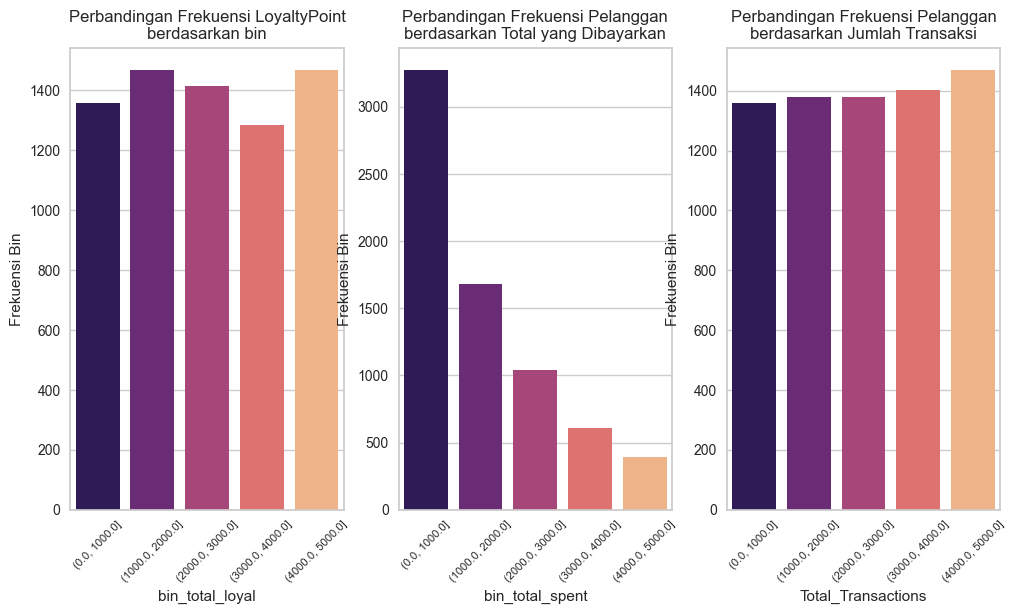

In [21]:
binned = ['bin_total_loyal', 'bin_total_spent', 'bin_total_loyal']
fig, ax = plt.subplots(1,3, figsize=(12,6))

df_num_1 = df_num.groupby('bin_total_loyal').agg('count')
sns.barplot(df_num_1, x='bin_total_loyal', y='Age', ax=ax[0], palette="magma")
ax[0].set_title("Perbandingan Frekuensi LoyaltyPoint\nberdasarkan bin")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)
ax[0].set_ylabel("Frekuensi Bin")

df_num_2 = df_num.groupby('bin_total_spent').agg('count')
sns.barplot(df_num_2, x='bin_total_spent', y='Age', ax=ax[1], palette="magma")
ax[1].set_title("Perbandingan Frekuensi Pelanggan\nberdasarkan Total yang Dibayarkan")
ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)
ax[1].set_ylabel("Frekuensi Bin")

df_num_2 = df_num.groupby('bin_total_transaction').agg('count')
sns.barplot(df_num_2, x='Total_Transactions', y='Age', ax=ax[2], palette="magma")
ax[2].set_title("Perbandingan Frekuensi Pelanggan\nberdasarkan Jumlah Transaksi")
ax[2].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)
ax[2].set_ylabel("Frekuensi Bin")

plt.show()

#### Insights:
* Telah dilakukan preprocessing data dengan standarisasi, pembatasan nilai outlier, dan encoding data kategorikan sehingga didapat 
* Perhatikan bahwa sebaran data hasil binning terlihat berbeda beda, berdasarkan loyalty point dan jumlah transaksi, didapat bahwa sebarannya cukup rata, sementara sebaran berdasarkan total yang dibayarkan memiliki sebaran right-skewed. Clustering menjadi tantangan dalam hal ini, karena sebarannya cukup berbeda bila dipengaruhi oleh total_spent

# 6. Pembangunan Model Clustering

## 6.1 Pembangunan Model Clustering

dalam hal ini, akan dibuat model clustering berdasarkan metode yang ditentukan

### 6.1.1 Model Clustering dengan seluruh Fitur

Dengan perspektif mencari k optimal berdasarkan silhouette terbesar. Selain itu, digunakan juga berdasarkan KElbowVisualizer seperti terlihat pada output dibawah

Optimal k: 2, Final Silhouette Score: 0.1451 




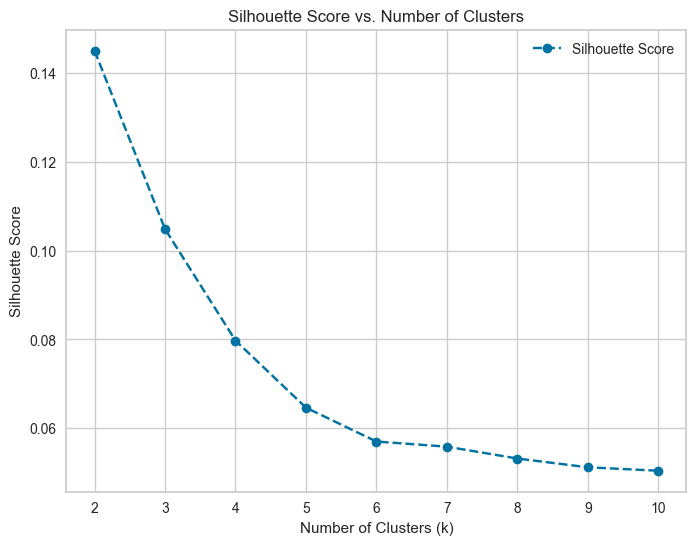

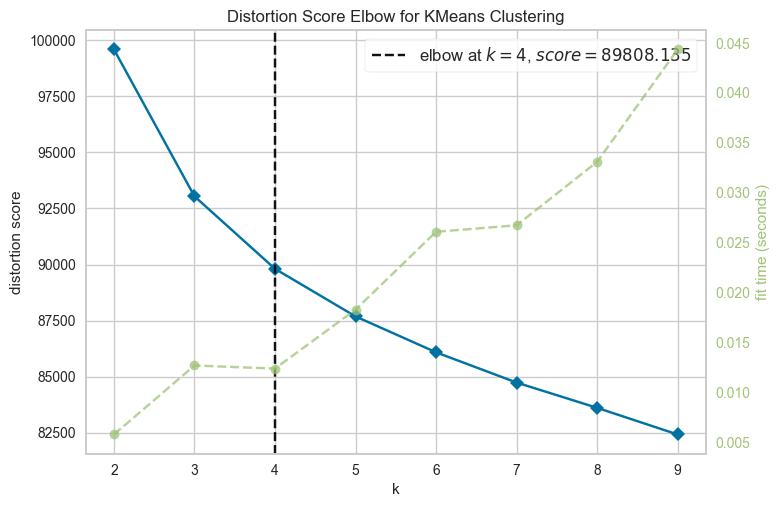

Optimal number of clusters (K): 4


In [22]:
model = {}
silhouette_scores = {}
inertia = []
sil_scores = []
K_range = range(2, 11)
kmeans_df = processed_df.copy()

def kmeans_without_pca(kmeans_df, K_range):
    for k in K_range:
        kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
        kmeans.fit(kmeans_df)
        inertia.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(kmeans_df, kmeans.labels_))
    
    optimal_k = K_range[np.argmax(sil_scores)]
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(kmeans_df)
    final_silhouette = silhouette_score(kmeans_df, kmeans_labels)
    silhouette_scores["K-Means tanpa PCA"] = final_silhouette
    model["K-Means tanpa PCA"] = [kmeans, kmeans_labels]
    print(f"Optimal k: {optimal_k}, Final Silhouette Score: {final_silhouette:.4f} \n\n")
    
    plt.figure(figsize=(8, 6))
    plt.plot(K_range, sil_scores, marker='o', linestyle='--', color='b', label='Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.legend()
    plt.show()

def visualizer_model(kmeans_df, k):
    visualizer = KElbowVisualizer(KMeans(random_state=42), k=k)
    visualizer.fit(kmeans_df) 
    visualizer.show()
    optimal_k = visualizer.elbow_value_
    print(f"Optimal number of clusters (K): {optimal_k}")

kmeans_without_pca(kmeans_df, K_range)
visualizer_model(kmeans_df, k=(2,10))

### 6.1.2 Model Clustering dengan menggunakan PCA dari seluruh fitur

berikut ini dibangun model menggunakan PCA (principal component analysis) dari seluruh fitur pada `processed_df` dengan n_components = 2

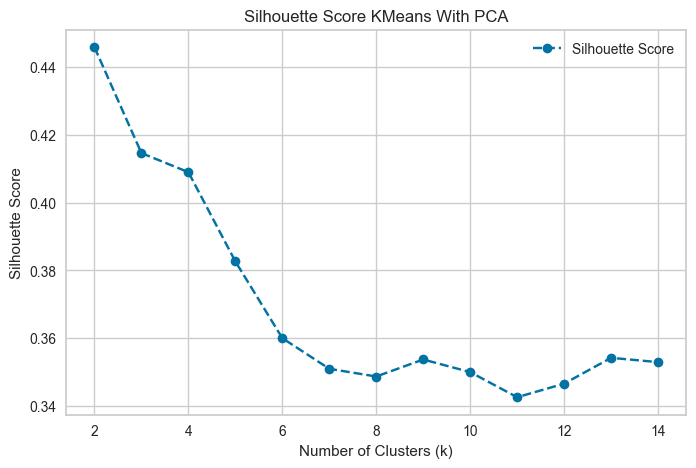

Optimal k: 2, Final Silhouette Score: 0.4458 




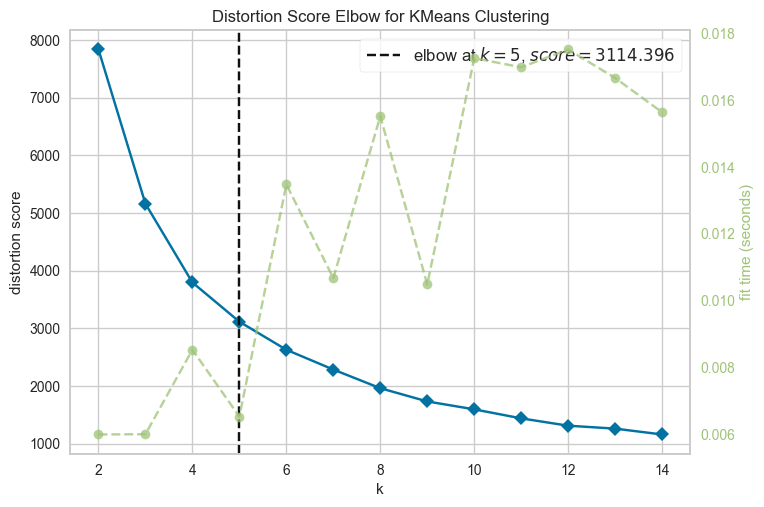

Optimal number of clusters (K): 5


In [23]:
def kmeans_with_pca(kmeans_df, K_range):
    sil_scores = []
    kmeans_df = processed_df.copy()
    scaler = RobustScaler()
    df_scaled = scaler.fit_transform(kmeans_df)

    pca = PCA(n_components=2)  
    df_pca = pca.fit_transform(df_scaled)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)  
        kmeans.fit(df_pca)
        
        labels = kmeans.labels_
        inertia.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(df_pca, labels))
    
    optimal_k = K_range[np.argmax(sil_scores)]
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=30)
    kmeans_labels = kmeans.fit_predict(df_pca)
    final_silhouette = silhouette_score(df_pca, kmeans_labels)
    
    silhouette_scores["K-Means dengan PCA dan Robust Scaler"] = final_silhouette
    model["K-Means dengan PCA n_components = 2"] = [kmeans, kmeans_labels]
    
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, sil_scores, marker='o', linestyle='--', color='b', label='Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score KMeans With PCA')
    plt.legend()
    plt.show()

    print(f"Optimal k: {optimal_k}, Final Silhouette Score: {final_silhouette:.4f} \n\n")

    return df_pca

def visualizer_model(kmeans_df, k):
    visualizer = KElbowVisualizer(KMeans(random_state=42), k=k)
    visualizer.fit(kmeans_df) 
    visualizer.show()
    optimal_k = visualizer.elbow_value_
    print(f"Optimal number of clusters (K): {optimal_k}")

df_pca = kmeans_with_pca(kmeans_df, K_range=range(2,15))
visualizer_model(df_pca, k=(2,15))

## 6.2 Evaluasi Model Clustering

Evaluasi model clustering digabung pada bagian 6.1. Selanjutnya perhatikan 2 output sebelumnya. Didapat bahwa:
* Model 6.1.1 yang melakukan clusterisasi **tanpa adanya PCA dan Robust scaling** mendapatkan silhouette score sebesar 0.1451 dengan optimal k berdasar silhouette score adalah 2, sementara optimal k berdasar Elbow methods adalah 4
* Model 6.1.2 yang melakukan clusterisasi melalui **PCA dan Robust Scaling** mendapatkan silhouette score lebih tinggi yakni 0.4458 dengan optimal k berdasar silhouette score adalah 2, sementara optimal k berdasar Elbow methods adalah 5

## 6.3 Feature Selection

Perhatikan correlation matrix, didapat bahwa korelasi tertinggi terhadap LTV adalah `Total_Spent`  yakni terkait dengan total biaya yang dikeluarkan oleh setiap pelanggan. Oleh karena itu, dilakukan **feature selection**, lebih tepatnya dengan harapan dapat memberikan silhouette score yang maksimal, diambil LTV dan Total Spent saja

### 6.3.1 Feature Extractions

Untuk mendapatkan hasil optimal, dilakukan multi-level clustering dengan KMeans clustering, dimana 
* K-Means cluster awal dilakukan dengan 3 cluster
* K-Means cluster kedua dilakukan dengan 4 cluster

#### 6.3.1.1 Model KMeans dengan Silhouette Score >= 0.7

In [24]:
def kmeans_sil_geq_zero_point_seven(df):
    extracted_df = df[["Total_Spent", 'LTV']].copy()
    variance_selector = VarianceThreshold(threshold=0.01) 
    processed_high_variance = variance_selector.fit_transform(extracted_df)  
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(processed_high_variance)
    
    pca = PCA(n_components=2) 
    transformed_data = pca.fit_transform(scaled_data)
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=30)
    kmeans.fit(transformed_data)
    
    all_clusters = kmeans.predict(transformed_data)
    sil_score = silhouette_score(transformed_data, all_clusters)
    print(f"Silhouette Score proses pertama: {sil_score:.4f}")
    
    extracted_df["Cluster"] = all_clusters
    
    variance_selector = VarianceThreshold(threshold=0.01) 
    processed_high_variance = variance_selector.fit_transform(extracted_df)  
    
    #Proses K-means kedua
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(processed_high_variance)
    
    pca = PCA(n_components=2) 
    transformed_data = pca.fit_transform(scaled_data)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=30)
    kmeans.fit(transformed_data)
    
    all_clusters_2 = kmeans.predict(transformed_data)
    sil_score = silhouette_score(transformed_data, all_clusters)
    print(f"Silhouette Score proses kedua: {sil_score:.4f}")

    return all_clusters_2, transformed_data

cluster_with_sil_score_high, cluster_data = kmeans_sil_geq_zero_point_seven(processed_df)


Silhouette Score proses pertama: 0.6115
Silhouette Score proses kedua: 0.7338


Perhatikan bahwa, Kmeans pada code block diatas memiliki Sihouette Score sebesar 0.7338 dengan terbentuk sebanyak 4 cluster di akhir proses. \
(dianggap sebagai pemenuhan kriteria minimum sil.score 0.7)

#### Membandingkan hasil tanpa dan dengan feature selection
* Sil.Score tanpa Feature selection: 0.44
* Sil.Score dengan Feature selection: 0.73
Ternyata didapat hasil silhouette score sebesar 0.73. yang menandakan bahwa sudah terpisah dengan baik, **lebih baik dibandingkan tanpa menggunakan feature selection**

Hasil KMeans yang ini lah **yang akan digunakan pada interpretasi dan tahap klasifikasi**

## 6.4. Visualisasi Hasil Clustering

Visualisasi dengan data hasil feature selection. note bahwa karena LTV dan Total_Spent memiliki koefisien korelasi bernilai 1, maka terlihat antara PCA component 1 dan PCA Component 2 seperti garis lurus

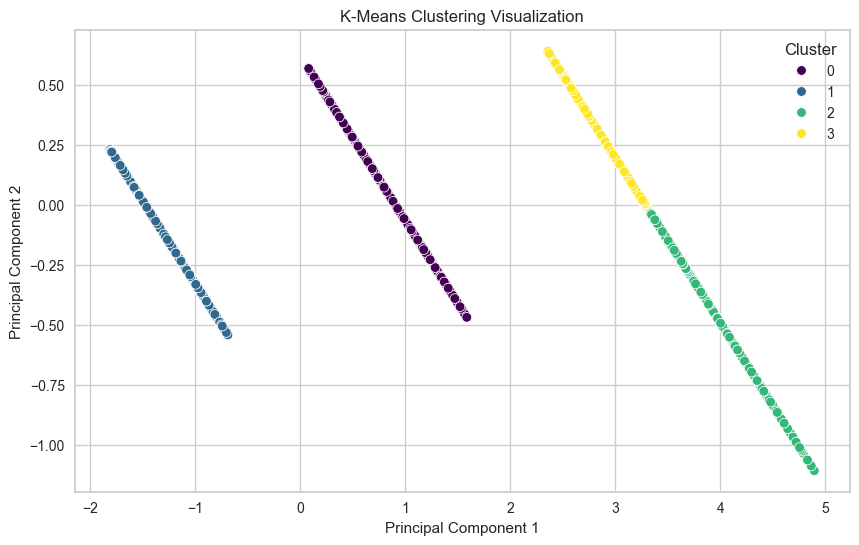

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(cluster_data, clusters):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=cluster_data[:, 0], y=cluster_data[:, 1], hue=clusters, palette='viridis', legend='full')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("K-Means Clustering Visualization")
    plt.legend(title="Cluster")
    plt.show()

plot_clusters(cluster_data, cluster_with_sil_score_high)


Visualisasi dengan menggunakan PCA pada dataset awal yakni `df` lalu dilakukan PCA dengan `n_components=2` supaya didapat dimensi yang dapat diinterpretasikan

In [26]:
kmeans_df = processed_df.copy()
scaler = RobustScaler()
df_scaled = scaler.fit_transform(checkpoint_df)

pca = PCA(n_components=2)  #2 dimensi saja supaya visualisasinya dapat dengan mudah diinterpretasikan
df_pca = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(df_pca.copy(), columns=["PCA Component 1", "PCA Component 2"])
pca_df["Cluster"] = cluster_with_sil_score_high

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_df["PCA Component 1"], 
    y=pca_df["PCA Component 2"], 
    hue=pca_df["Cluster"], 
    palette="viridis", 
    alpha=0.8
)
plt.title("visualisasi Hasil Clustering")

Text(0.5, 1.0, 'visualisasi Hasil Clustering')

Secara garis besar, dataset terpisah dengan cukup baik

## 6.5 Analisis dan Interpretasi Hasil Cluster

### 6.5.1 menambahkan Hasil Label Cluster ke DataFrame

**Tidak dilakukan `invers_transform`** karena tidak ada shuffling pada `df` dan **hasil clustering**. Dengan begitu, hasil clustering langsung diconcat ke data asli yakni `df`. Interpretasi dan penjelasan bagian ini akan digabung pada subbab selanjutnya

In [28]:
if len(df) == len(cluster_with_sil_score_high):
    df['Cluster'] = cluster_with_sil_score_high
else:
    print("Jumlah baris tidak cocok antara df dan transformed_data!")

Kode diatas memastikan jumlah baris keduanya sesuai

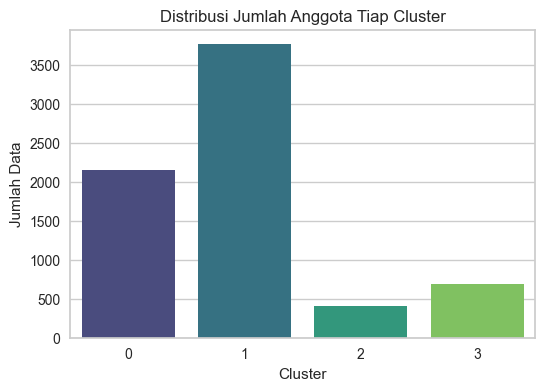

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Cluster"], palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Jumlah Anggota Tiap Cluster")
plt.show()

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x=df["Cluster"], y=df["Total_Spent"], palette="viridis", ax=axes[0])
axes[0].set_title("Distribusi Total Spent per Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Total Spent")

sns.boxplot(x=df["Cluster"], y=df["LTV"], palette="viridis", ax=axes[1])
axes[1].set_title("Distribusi LTV per Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("LTV")

plt.tight_layout()
plt.show()

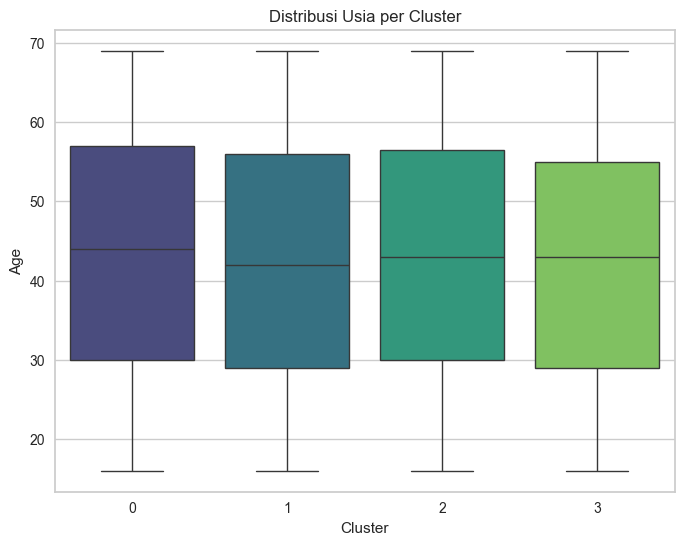

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["Cluster"], y=df["Age"], palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Age")
plt.title("Distribusi Usia per Cluster")
plt.show()

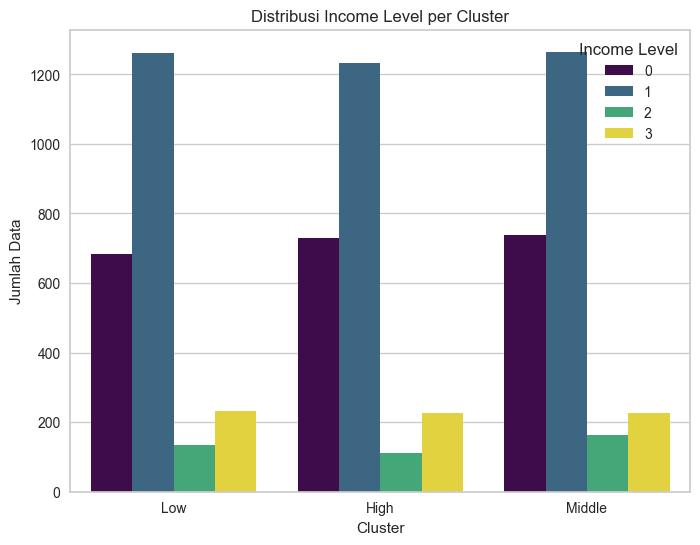

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df["Income_Level"], hue=df["Cluster"], palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Income Level per Cluster")
plt.legend(title="Income Level")
plt.show()

In [33]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["Cluster"], y=df["Total_Transactions"], palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Total Transactions")
plt.title("Distribusi Total Transactions per Cluster")
plt.show()

Interpretasi hasil grafik akan dijelaskan pada poin-poin di bawah ini

### 6.5.2 Interpretasi dan Analisis

Poin interpretasi dan Analisis Digabung menjadi satu

In [34]:
df[df['Cluster'] == 0].describe()

Age  Total_Transactions  Avg_Transaction_Value  \
count  2151.000000         2151.000000            2151.000000   
mean     43.216179          604.973966           12084.203992   
std      15.654058          199.321564            4009.198630   
min      16.000000          214.000000            4343.252538   
25%      30.000000          444.000000            8794.920927   
50%      44.000000          589.000000           11676.179461   
75%      57.000000          757.000000           15272.710727   
max      69.000000         1000.000000           19993.899679   

       Max_Transaction_Value  Min_Transaction_Value   Total_Spent  \
count            2151.000000            2151.000000  2.151000e+03   
mean            36729.940745            3611.188973  6.685756e+06   
std             18877.748131            1889.578037  1.593440e+06   
min              5063.256631             582.238204  4.157093e+06   
25%             22156.214144            2104.716445  5.277625e+06   
50%             33128.999987            3236.334962  6.516898e+06   
75%             48241.167254            4795.438177  8.003117e+06   
max             92952.041393            9097.298648  9.889235e+06   

       Active_Days  Last_Transaction_Days_Ago  Loyalty_Points_Earned  \
count  2151.000000                2151.000000            2151.000000   
mean    184.927011                 182.644816            2523.833566   
std     104.648247                 105.871437            1447.101330   
min       1.000000                   1.000000               1.000000   
25%      93.500000                  90.000000            1247.000000   
50%     188.000000                 181.000000            2506.000000   
75%     277.000000                 275.500000            3832.500000   
max     365.000000                 365.000000            5000.000000   

       Referral_Count  Cashback_Received  Support_Tickets_Raised  \
count     2151.000000        2151.000000             2151.000000   
mean        24.829847        2505.482964                9.966527   
std         14.528972        1450.791811                5.915749   
min          0.000000           0.234349                0.000000   
25%         13.000000        1266.490500                5.000000   
50%         25.000000        2526.694650               10.000000   
75%         37.000000        3739.772154               15.000000   
max         50.000000        4998.449387               20.000000   

       Issue_Resolution_Time  Customer_Satisfaction_Score           LTV  \
count            2151.000000                  2151.000000  2.151000e+03   
mean               36.586584                     5.472338  6.803258e+05   
std                20.195732                     2.902613  1.593936e+05   
min                 1.109725                     1.000000  4.304551e+05   
25%                19.452388                     3.000000  5.393829e+05   
50%                36.146653                     5.000000  6.633140e+05   
75%                53.675827                     8.000000  8.113907e+05   
max                71.973629                    10.000000  1.000151e+06   

       Cluster  
count   2151.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0

#### Cluster 0 - Pelanggan Pasif & Rendah Nilai
* Usia rata-rata: 39 tahun (rentang 18–67 tahun).
* Jumlah transaksi: 237 transaksi per tahun (terendah).
* Hari aktif: 53 hari, menunjukkan keterlibatan yang rendah.
* Total pengeluaran: Rp2,67 juta, jauh lebih kecil dibanding klaster lain.
* Loyalitas & insentif:
  * Poin loyalitas 274 (terendah).
  * Rata-rata referral hanya 3 orang, menunjukkan rendahnya pengaruh pelanggan ini dalam program referensi.
  * LTV (Lifetime Value): Rp270 ribu, menjadikan mereka pelanggan dengan nilai terendah.

**Analisis dan Kesimpulan:**
* Pelanggan ini memiliki sedikit transaksi dan pengeluaran rendah.
* Mungkin hanya belanja saat promo atau kebutuhan mendesak.
* Perlu strategi peningkatan keterlibatan dan insentif loyalitas agar lebih aktif.

In [35]:
df[df['Cluster'] == 1].describe()

Age  Total_Transactions  Avg_Transaction_Value  \
count  3759.000000         3759.000000            3759.000000   
mean     42.328279          352.704975            6882.802991   
std      15.503651          263.969711            5252.836166   
min      16.000000            1.000000              10.185827   
25%      29.000000          137.000000            2738.204879   
50%      42.000000          279.000000            5393.126442   
75%      56.000000          537.000000           10209.398551   
max      69.000000         1000.000000           19996.445086   

       Max_Transaction_Value  Min_Transaction_Value   Total_Spent  \
count            3759.000000            3759.000000  3.759000e+03   
mean            20693.827224            2051.707131  1.703578e+06   
std             18712.441753            1871.257567  1.227148e+06   
min                31.857484               4.617966  1.498144e+03   
25%              6683.164338             642.247963  5.949786e+05   
50%             14955.098975            1485.353372  1.492964e+06   
75%             29165.013909            2867.723453  2.686878e+06   
max             92952.041393            9097.298648  4.218979e+06   

       Active_Days  Last_Transaction_Days_Ago  Loyalty_Points_Earned  \
count  3759.000000                3759.000000            3759.000000   
mean    181.549614                 184.413408            2495.657090   
std     105.855533                 104.779933            1451.030829   
min       1.000000                   1.000000               0.000000   
25%      89.000000                  94.000000            1254.000000   
50%     180.000000                 186.000000            2454.000000   
75%     274.000000                 275.000000            3791.500000   
max     365.000000                 365.000000            5000.000000   

       Referral_Count  Cashback_Received  Support_Tickets_Raised  \
count     3759.000000        3759.000000             3759.000000   
mean        25.100293        2506.588206               10.146848   
std         14.597611        1433.809759                6.061485   
min          0.000000           1.350612                0.000000   
25%         12.000000        1292.404263                5.000000   
50%         25.000000        2484.371474               10.000000   
75%         38.000000        3752.411698               15.000000   
max         50.000000        4999.698480               20.000000   

       Issue_Resolution_Time  Customer_Satisfaction_Score            LTV  \
count            3759.000000                  3759.000000    3759.000000   
mean               36.504396                     5.461825  182067.630712   
std                20.405754                     2.856338  122787.950191   
min                 1.019853                     1.000000    3770.495425   
25%                19.111947                     3.000000   71136.533255   
50%                36.236188                     5.000000  161966.630809   
75%                54.248302                     8.000000  281198.077010   
max                71.978946                    10.000000  434897.541983   

       Cluster  
count   3759.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

#### Cluster 1 - Pelanggan Rutin & Moderat
* Usia rata-rata: 37 tahun.
* Jumlah transaksi: 512 transaksi per tahun.
* Hari aktif: 125 hari, lebih sering berbelanja dibanding cluster 0.
* Total pengeluaran: Rp6,97 juta, dua kali lipat dari cluster 0.
* Loyalitas & insentif:
  * Poin loyalitas 1033, lebih tinggi dari cluster 0.
  * Referral 11 orang, menunjukkan adanya keterlibatan dalam program referensi.
  * Cashback Rp1,1 juta, menunjukkan insentif lebih besar dibanding cluster 0.
  * LTV: Rp620 ribu, menunjukkan bahwa cluster ini berpotensi menjadi pelanggan bernilai lebih tinggi jika diberi dorongan lebih lanjut.

**Analisis dan Kesimpulan:**
* Pelanggan ini cukup aktif, tetapi masih dapat ditingkatkan dengan promosi yang lebih menarik.
* cluster mulai menunjukkan loyalitas, sehingga program khusus pelanggan tetap bisa lebih efektif di sini.

In [36]:
df[df['Cluster'] == 2].describe()

Age  Total_Transactions  Avg_Transaction_Value  \
count  407.000000          407.000000             407.000000   
mean    42.997543          884.894349           17769.551157   
std     15.221274           80.181482            1587.414180   
min     16.000000          692.000000           13807.966168   
25%     30.000000          826.500000           16702.719582   
50%     43.000000          898.000000           18058.531241   
75%     56.500000          952.000000           19113.770151   
max     69.000000         1000.000000           19995.491807   

       Max_Transaction_Value  Min_Transaction_Value   Total_Spent  \
count             407.000000             407.000000  4.070000e+02   
mean            54337.689945            5479.795428  1.546458e+07   
std             20884.532430            2095.385017  1.221551e+06   
min             15739.183060            1470.575987  1.359455e+07   
25%             35778.924597            3805.519621  1.430178e+07   
50%             54960.803659            5420.423408  1.537185e+07   
75%             71650.165586            7213.058688  1.676905e+07   
max             92952.041393            9097.298648  1.706778e+07   

       Active_Days  Last_Transaction_Days_Ago  Loyalty_Points_Earned  \
count   407.000000                 407.000000             407.000000   
mean    171.977887                 186.292383            2424.840295   
std     102.938917                 103.510431            1444.769548   
min       1.000000                   2.000000               0.000000   
25%      84.000000                 102.000000            1219.000000   
50%     167.000000                 186.000000            2314.000000   
75%     255.000000                 275.500000            3595.500000   
max     365.000000                 364.000000            5000.000000   

       Referral_Count  Cashback_Received  Support_Tickets_Raised  \
count      407.000000         407.000000              407.000000   
mean        25.110565        2446.580108                9.889435   
std         14.719882        1383.224373                6.174400   
min          0.000000           5.107495                0.000000   
25%         12.000000        1309.879522                5.000000   
50%         25.000000        2395.664872               10.000000   
75%         39.000000        3661.166602               15.000000   
max         50.000000        4987.630136               20.000000   

       Issue_Resolution_Time  Customer_Satisfaction_Score           LTV  \
count             407.000000                   407.000000  4.070000e+02   
mean               36.250763                     5.479115  1.557357e+06   
std                20.818941                     2.797594  1.212157e+05   
min                 1.098926                     1.000000  1.367243e+06   
25%                17.893664                     3.000000  1.438793e+06   
50%                36.703506                     5.000000  1.548165e+06   
75%                54.455099                     8.000000  1.690042e+06   
max                71.510694                    10.000000  1.714836e+06   

       Cluster  
count    407.0  
mean       2.0  
std        0.0  
min        2.0  
25%        2.0  
50%        2.0  
75%        2.0  
max        2.0

#### Cluster 2 - Pelanggan Setia & Transaksi Tinggi
* Usia rata-rata: 35 tahun (termuda dari semua klaster).
* Jumlah transaksi: 1002 transaksi per tahun (tertinggi).
* Hari aktif: 298 hari, hampir sepanjang tahun mereka melakukan transaksi.
* Total pengeluaran: Rp13,59 juta, tertinggi dari semua klaster.
* Loyalitas & insentif:
  * Poin loyalitas 4750, yang tertinggi.
  * Referral 47 orang, menunjukkan mereka sangat aktif dalam mereferensikan pelanggan lain.
  * Cashback Rp4,97 juta, sangat tinggi dibanding cluster lain.
  * LTV: Rp1,37 juta, menjadikan cluster ini merupakan pelanggan paling bernilai.

**Analisis dan Kesimpulan:**
* Cluster ini adalah pelanggan VIP dengan loyalitas tinggi dan frekuensi transaksi yang luar biasa.
* layak untuk mendapat treatment khusus, seperti program premium atau personalisasi layanan.
* Fokus utama: Memastikan pelanggan pada cluster tetap puas agar tidak pindah ke kompetitor.

In [37]:
df[df['Cluster'] == 3].describe()

Age  Total_Transactions  Avg_Transaction_Value  \
count  683.000000          683.000000             683.000000   
mean    42.263543          763.222548           15417.326242   
std     15.295552          126.140941            2469.849654   
min     16.000000          497.000000           10065.851886   
25%     29.000000          663.500000           13328.299586   
50%     43.000000          760.000000           15194.261726   
75%     55.000000          866.000000           17540.714182   
max     69.000000          999.000000           19987.065068   

       Max_Transaction_Value  Min_Transaction_Value   Total_Spent  \
count             683.000000             683.000000  6.830000e+02   
mean            47102.193608            4613.970596  1.149815e+07   
std             19479.016735            1950.902634  1.034464e+06   
min             11225.548706            1258.799055  9.860581e+06   
25%             31290.854273            2967.421611  1.060833e+07   
50%             46495.951858            4526.162376  1.137301e+07   
75%             60433.162242            6008.850257  1.233970e+07   
max             92952.041393            9097.298648  1.356724e+07   

       Active_Days  Last_Transaction_Days_Ago  Loyalty_Points_Earned  \
count   683.000000                 683.000000             683.000000   
mean    180.565154                 183.065886            2509.468521   
std     103.432170                 105.167999            1423.633572   
min       1.000000                   1.000000               6.000000   
25%      93.000000                  97.000000            1336.500000   
50%     180.000000                 177.000000            2532.000000   
75%     266.500000                 273.000000            3715.000000   
max     365.000000                 365.000000            4989.000000   

       Referral_Count  Cashback_Received  Support_Tickets_Raised  \
count      683.000000         683.000000              683.000000   
mean        23.247438        2442.691364                9.543192   
std         14.285997        1480.498574                6.181929   
min          0.000000          12.789262                0.000000   
25%         11.000000        1107.909298                4.000000   
50%         23.000000        2365.935884                9.000000   
75%         34.000000        3782.795620               15.000000   
max         50.000000        4974.614858               20.000000   

       Issue_Resolution_Time  Customer_Satisfaction_Score           LTV  \
count             683.000000                   683.000000  6.830000e+02   
mean               36.638681                     5.594436  1.161531e+06   
std                20.689339                     2.786293  1.032955e+05   
min                 1.500344                     1.000000  9.949874e+05   
25%                18.949043                     3.000000  1.071419e+06   
50%                36.723516                     6.000000  1.151764e+06   
75%                53.724590                     8.000000  1.244476e+06   
max                71.944062                    10.000000  1.370570e+06   

       Cluster  
count    683.0  
mean       3.0  
std        0.0  
min        3.0  
25%        3.0  
50%        3.0  
75%        3.0  
max        3.0

#### Cluster 3 - Pelanggan Potensial dengan Nilai Tinggi
* Usia rata-rata: 42 tahun (paling tua di antara semua cluster).
* Jumlah transaksi: 763 transaksi per tahun.
* Hari aktif: 180 hari, cukup sering bertransaksi tetapi ada indikasi penurunan aktivitas.
* Total pengeluaran: Rp11,49 juta, menunjukkan daya beli yang tinggi.
* Loyalitas & insentif:
  * Poin loyalitas 2509, di atas rata-rata.
  * Referral 23 orang, masih tergolong tinggi.
  * Cashback Rp2,44 juta, cukup besar.
* Interaksi layanan pelanggan:
  * 9 tiket support per tahun dengan waktu penyelesaian 36,6 hari, menunjukkan adanya potensi ketidakpuasan.
  * Skor kepuasan 5,59 dari 10, menunjukkan ruang perbaikan.
  * LTV: Rp1,16 juta, hampir setara dengan cluster 2.

**Kesimpulan:**
* Pelanggan ini bernilai tinggi tetapi memiliki beberapa tantangan, seperti kepuasan pelanggan yang perlu ditingkatkan.
* Banyak dari pelanggan di cluster ini yang mungkin sudah mulai jarang bertransaksi (183 hari sejak transaksi terakhir).
* Strategi: Fokus pada program retensi dan peningkatan layanan pelanggan agar tidak berpindah ke kompetitor.

### 6.5.3 Kesimpulan

**Kesimpulan utama:**
* Cluster 2 adalah pelanggan terbaik, yang harus dipertahankan dengan program eksklusif.
* Cluster 3 memiliki potensi besar, tetapi ada risiko churn jika kepuasan mereka tidak diperbaiki.
* Cluster 1 adalah target potensial untuk diubah menjadi pelanggan setia.
* Cluster 0 adalah tantangan utama, karena mereka cenderung pasif dan sulit ditingkatkan tanpa insentif besar.

# 7. Mengeksport Data

In [38]:
df.to_csv("Dataset_inisiasi.csv", index=False)